# Example 1: Interaction Indices for a Gradient Boosted Tree on the Folktables Income data set

In [1]:
import xgboost

from folktables import ACSDataSource, ACSIncome

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", rc={'axes.linewidth': 2, 'grid.linewidth': 1},  font_scale=1.5)

import nshap

### Load the data

In [2]:
data_source = ACSDataSource(survey_year='2016',
                            horizon = '1-Year', 
                            survey = 'person',
                            root_dir = '../data/')
data = data_source.get_data(states=["CA"], download=True)
X, Y, _ = ACSIncome.df_to_numpy(data)                            
feature_names = ACSIncome.features
    
# zero mean and unit variance for all features
X = StandardScaler().fit_transform(X)

# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=0)

In [3]:
# reduce input dimension to speed up computation
X_train = X_train[:, 0:8]
X_test = X_test[:, 0:8]
feature_names = feature_names[0:8]

### Train the classifier

In [4]:
gbtree = xgboost.XGBClassifier()
gbtree.fit(X_train, Y_train)
print(f'Accuracy: {accuracy_score(Y_test, gbtree.predict(X_test)):0.3f}')

Accuracy: 0.830


### Define the value function

In [5]:
vfunc = nshap.vfunc.interventional_shap(gbtree.predict_proba, X_train, target=0)

### Compute n-Shapley Values

In [6]:
%%time
n_shapley_values = nshap.n_shapley_values(X_test[0, :], vfunc) # with 8 variables, this takes about 5 minutes

CPU times: total: 58min 39s
Wall time: 4min 7s


In [7]:
n_shapley_values.save('n-shapley-values.json')

In [8]:
n_shapley_values = nshap.load('n-shapley-values.json') # load the pre-computed result instead

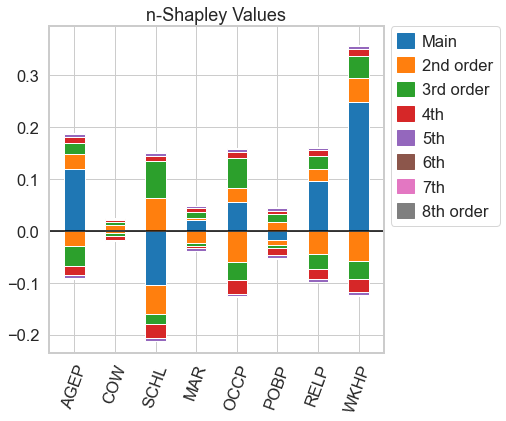

<AxesSubplot:title={'center':'n-Shapley Values'}>

In [9]:
n_shapley_values.plot(feature_names = feature_names)

#### From the n-Shapley Values, we can obtain the 3-Shapley Values

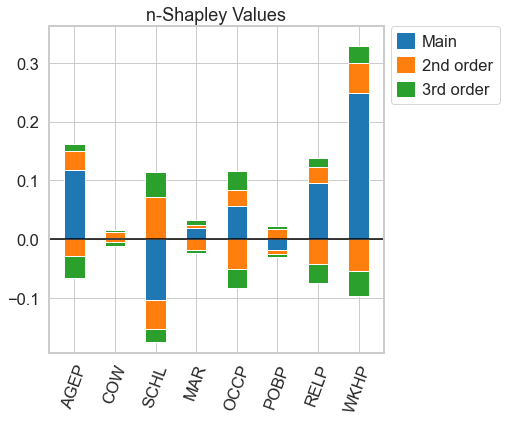

In [10]:
n_shapley_values.k_shapley_values(3).plot(feature_names = feature_names)
plt.show()

#### ... Shapley Interaction Values (with the interventaional Shap Value function, these the SHAP interaction values from the shap package)

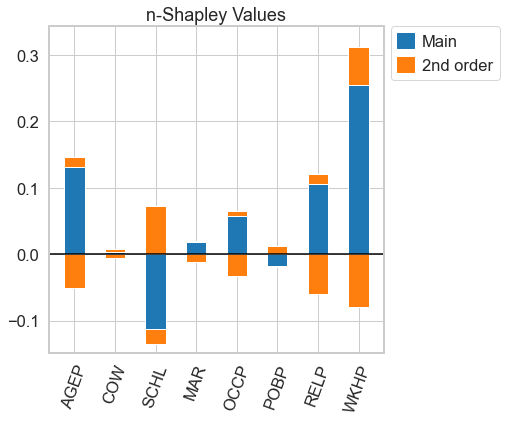

<AxesSubplot:title={'center':'n-Shapley Values'}>

In [11]:
n_shapley_values.k_shapley_values(2).plot(feature_names = feature_names)

#### ... and the usual Shapley Values

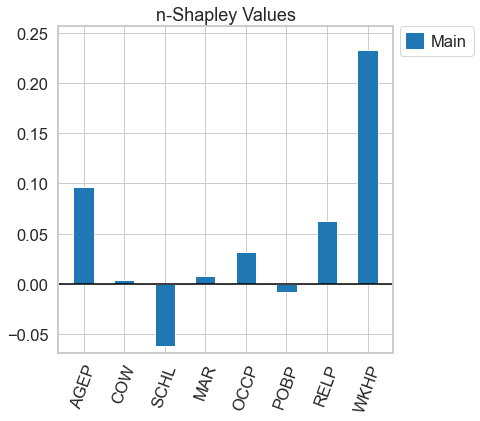

<AxesSubplot:title={'center':'n-Shapley Values'}>

In [12]:
n_shapley_values.k_shapley_values(1).plot(feature_names = feature_names)

In [13]:
import shap
shap.initjs()

In [14]:
shap.force_plot(vfunc(X_test[0,:], []), n_shapley_values.shapley_values())

### Let's compare this to the Shapley Values from the shap package

In [15]:
explainer = shap.KernelExplainer(gbtree.predict_proba, shap.kmeans(X_train, 25))

shap_values = explainer.shap_values(X_test[0, :])

In [16]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

### Now, let us repeat this exercise with the the Shapley Taylor interaction index

In [17]:
shapely_taylor = nshap.shapley_taylor(X_test[0, :], vfunc)

In [18]:
shapely_taylor.save('shapley-taylor.json')

In [19]:
shapely_taylor = nshap.load('shapley-taylor.json')

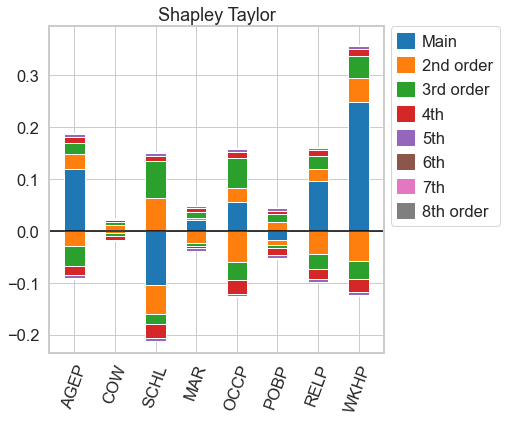

<AxesSubplot:title={'center':'Shapley Taylor'}>

In [20]:
# for n=d, both n-Shapley Values and the Shapley Taylor interaction index are equal to the Möbius transform, so we get the same picture as above
shapely_taylor.plot(feature_names = feature_names)

In [21]:
nshap.allclose(n_shapley_values, shapely_taylor)

True

In [22]:
# more useful functions for the shapley taylor interaction index might come in the future. for now, we have to compute the index again for every order
k_shapely_taylor = nshap.shapley_taylor(X_test[0, :], vfunc, 3)

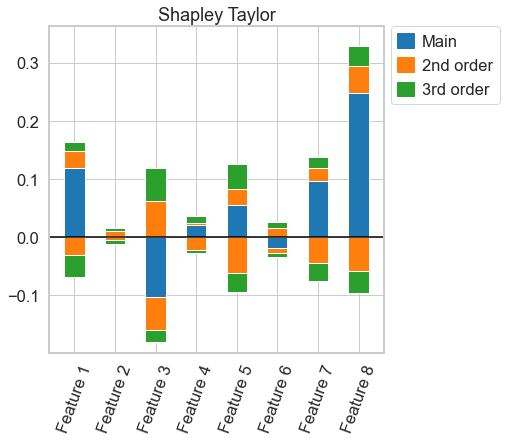

<AxesSubplot:title={'center':'Shapley Taylor'}>

In [23]:
# this plot, again, is almost the same as for 3-Shapley Values. A very close comparison of the two figures reveal, however, that they are not exactly the same
k_shapely_taylor.plot()

In [24]:
nshap.allclose(n_shapley_values.k_shapley_values(3), k_shapely_taylor) # this confirms that the interaction indices are not exactly the same

False

### Now, the same exercise for Faith-Shap interaction index

In [25]:
faith_shap = nshap.faith_shap(X_test[0, :], vfunc)

In [26]:
faith_shap.save('faith-shap.json')

In [27]:
faith_shap = nshap.load('faith-shap.json')

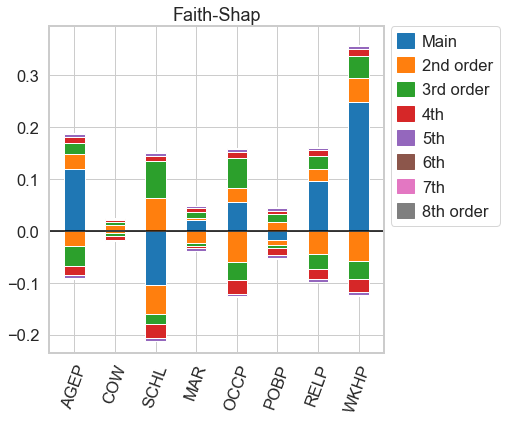

<AxesSubplot:title={'center':'Faith-Shap'}>

In [28]:
# for n=d, both n-Shapley Values and the Faith-Shap index are equal to the Möbius transform, so we get the same picture as above
faith_shap.plot(feature_names = feature_names)

In [29]:
nshap.allclose(n_shapley_values, faith_shap)

True

In [30]:
# more useful functions for the Faith-Shap interaction index might come in the future. for now, we have to compute the index again for every order
k_faith_shap = nshap.faith_shap(X_test[0, :], vfunc, 3)

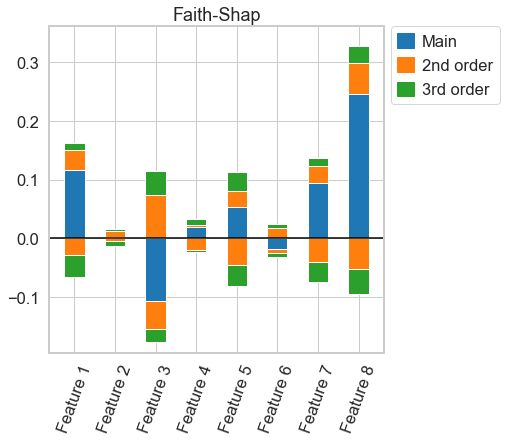

<AxesSubplot:title={'center':'Faith-Shap'}>

In [31]:
# this plot, again, is almost the same as for 3-Shapley Values. A very close comparison of the two figures reveal, however, that they are not exactly the same
k_faith_shap.plot()

In [32]:
# again, the figure is very similar, but the interaction indices are not actually the same
nshap.allclose(n_shapley_values.k_shapley_values(3), k_faith_shap), nshap.allclose(k_shapely_taylor, k_faith_shap)

(False, False)